## Introduction

Hello again. In this exercise we are going to
1. use pre-trained model for classification,
2. calculate saliency of the image - what regions the classification decision is most sensitive to,
3. create fooling images (called adversarial examples) for neural networks.

We are going to use ResNet-50 model included with PyTorch. For more information about the model see [this paper](https://arxiv.org/abs/1512.03385).

In [ ]:
import torch
import torchvision.models as models

# Load pretrained ResNet50 model
model = models.resnet50(pretrained=True)

In [ ]:
from torchsummary import summary

summary(model, (3, 224, 224))

**Task 3.1:** 

What is the number of parameters? What is the number of weight layers? Where ResNet gets its name? Alternatively to summary: You can also check the number of parameters by iterating over model.parameters() and counting total value of parameters. 

**Your answer:** 

**NB!** If you are working in google colab, upload elephant image (which was in your homework archieve) to your files folder in goole colab.

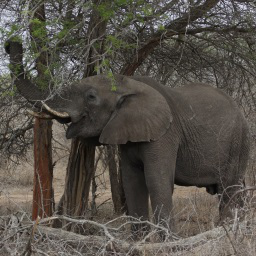

In [ ]:
from PIL import Image
from torchvision import transforms

img = Image.open('elephant.jpg')
img

In [ ]:
# Preprocess the image using ImageNet transformation so it has same shape as pretrained inputs
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(img)
input_batch = input_tensor.unsqueeze(0)  # Create a mini-batch as expected by the model

The specific numbers used in the transformations are based on the preprocessing steps and normalization statistics used during the training of the ResNet50 model on the ImageNet dataset.

- `transforms.Resize(256)`: ResNet50 models are trained on images that are resized to have the smaller side be 256 pixels. This transformation resizes the image so that the smaller side has a length of 256 pixels while maintaining the aspect ratio.

- `transforms.CenterCrop(224)`: ResNet50 models are trained on 224x224 pixel images. After resizing the image to have the smaller side be 256 pixels, a 224x224 crop is taken from the center of the image. This ensures that the input image has the same spatial dimensions as the images used during training.

- `transforms.ToTensor()`: This transformation converts the image from a PIL image format to a PyTorch tensor format. It also scales the pixel values from the range [0, 255] to the range [0, 1].

- `transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])`: The mean and standard deviation values used in this transformation are calculated from the ImageNet dataset. The model was trained with these normalization statistics, so it is essential to apply the same normalization to any input images. This step normalizes the pixel values in each color channel (RGB) by subtracting the mean and dividing by the standard deviation.

In [ ]:
#Move the input to GPU (if available) and perform inference
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_batch = input_batch.to(device)
model.to(device)
model.eval()

with torch.no_grad():
    output = model(input_batch)

# Get probabilities
probabilities = torch.nn.functional.softmax(output[0], dim=0)


In [ ]:
# Get top 5 predictions
topk_probs, topk_indices = probabilities.topk(5)

Let's find the correspondence between predicted class indeces and their actual class names, by checking `imagenet_classes.txt`. 
**NB!** Again if you are using google colab load the file to your folder.

In [ ]:
# Load ImageNet class names
with open("imagenet_classes.txt", "r") as f:
    class_names = [line.strip().split(": ")[1].strip("',") for line in f.readlines()]

In [ ]:

# Get class names and print results
predictions = [(class_names[i], prob) for i, prob in zip(topk_indices, topk_probs)]
print(predictions)

### Saliency maps

For saliency maps we need to calculate gradient of the input image with respect to the class probability (or score). Basically this tells us, which part of the image the model is most sensitive to.

In [ ]:
import numpy as np


# Ensure the model is in training mode (For testing we would use model.eval())
model.train()

# Enable gradients for the input image
model.requires_grad_(True)
input_batch.requires_grad_(True)

# Forward pass and backward pass
output = model(input_batch)
label = output.argmax().item()
output[0, label].backward()

# Get the gradients
x_grads = input_batch.grad.cpu().numpy()

x_grads.shape


(1, 3, 224, 224)

**Task 3.2:** 

Which layers behave differently in train/test phase?

**Your answer:** 

**Task 3.3:** 

We are interested in sensitivity to pixel locations, ignoring the sign and color channels.

In [ ]:
##############################################################################
# TODO: Take absolute values of the gradients and maximum over channels.     #
#       Make sure that you know which dimension represent channels           #
##############################################################################
x_saliency = None
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################
assert x_saliency.shape == input_batch.shape[2:]

In [ ]:
import numpy as np

# Denormalize the image to look it the same as the image we loaded initially
def decode_image(x):
    x = x.permute(1, 2, 0).numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    return np.clip((x * std + mean) * 255, 0, 255).astype(np.uint8)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(decode_image(input_tensor.cpu()))
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(x_saliency, cmap="gray")
plt.axis("off")

**Task 3.4:** 

What parts of the image is the classifier sensitive to?

**Your answer:**



### Fooling the network

Now we are going to create a picture that looks very much like an elephant, but the network classifies it as something completely irrelevant. Being easily fooled is well known problem of neural networks and is active area of research. For more information and references see [this blog post](https://blog.openai.com/adversarial-example-research/).

For this we are going to calculate the gradients of target class probablity w.r.t. the input image and perform gradient ascent, i.e. change the picture so that the target class has the highest probability.

In [ ]:
# for fun we choose paper towel :)
target = 700
print(target, class_names[target])

In [ ]:
import torch.nn.functional as F

# Define a function to perform a forward pass and calculate gradients
def grads_fool(input_tensor, target):
    model.zero_grad()
    input_tensor.requires_grad_(True)

    output = model(input_tensor)
    # Depending of weather we use softmax here we got either probabilities or logits
    # Let's see logits since the value change is more visible for this task
    #output_softmax = F.softmax(output, dim=1)
    target_score = output[0, target]
    target_score.backward()

    return output.detach().cpu().numpy(), input_tensor.grad.cpu().numpy()

**Task 3.5:** 

Implement gradient ascent to change the input image so that the target class probability increases

In [ ]:
# Implement gradient ascent
learning_rate = 0.05
input_tensor_fake = input_tensor.clone().to(device)
for i in range(100):
    preds, x_grads = grads_fool(input_tensor_fake.unsqueeze(0), target)

    new_label = np.argmax(preds)

    print(i, ':', "current class:", class_names[new_label], "(%.02f)" % preds[0, new_label], "target class:", class_names[target], "(%.02f)" % preds[0, target])
    if new_label == target:
        break


    ##############################################################################
    # TODO: Implement gradient ascent to change the input image so that the      #
    #       target class probability increases. NB! You should normalize the     #
    #       gradients using L2 norm before multiplying them with learning rate   #
    #       and adding to the input image.                                       #
    #       For input_tensor_fake update make sure to put x_grads to tensor with #            
    #       torch.tensor(x_grads).to(device) function                            #
    #       To make sure match shapes between x_grades and input_tensor_fake     #
    #       you can use .view_as(input_tensor_fake) funciton                     #
    ##############################################################################
    x_grads = 
    input_tensor_fake += 
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################

In [ ]:
def decode_image(x):
    x = x.clone()
    x = x * torch.tensor([0.229, 0.224, 0.225], device=x.device).view(1, 3, 1, 1) + torch.tensor([0.485, 0.456, 0.406], device=x.device).view(1, 3, 1, 1)
    return x

In [ ]:
input_image_decoded = decode_image(input_tensor).squeeze(0)
input_image_fake_decoded = decode_image(input_tensor_fake).squeeze(0)
differences = decode_image(input_tensor - input_tensor_fake).squeeze(0)
differences_amplified = decode_image((input_tensor - input_tensor_fake) * 10).squeeze(0)

to_pil = transforms.ToPILImage()

plt.figure(figsize=(16,8))

plt.subplot(1,4,1)
plt.imshow(to_pil(input_image_decoded.cpu()))
plt.title(class_names[label])
plt.axis('off')

plt.subplot(1,4,2)
plt.imshow(to_pil(input_image_fake_decoded.cpu()))
plt.title(class_names[target])
plt.axis('off')

plt.subplot(1,4,3)
plt.imshow(to_pil(differences.cpu()))
plt.title("differences")
plt.axis('off')

# it's hard to even see the diffferences, so let's amplify them
plt.subplot(1,4,4)
plt.imshow(to_pil(differences_amplified.cpu()))
plt.title("differences x10")
plt.axis('off')

**Task 3.6:** 

What are the potential implications of adversarial examples?

**Your answer:**